In [1]:
import emcee
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from matplotlib.ticker import MaxNLocator
import pandas as pd

So we'll just do a simple linear model, and add some noise. We'll then use mcmc to estimate the slope and intercept parameters of this model.

In [2]:

np.random.seed(123)

# Choose the "true" parameters.
m_true = .75
b_true = 2
sigma_true = 2

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = sigma_true* np.random.rand(N)
y = m_true*x+b_true
y += yerr * np.random.randn(N)

Taking a look at the sample data we generated.

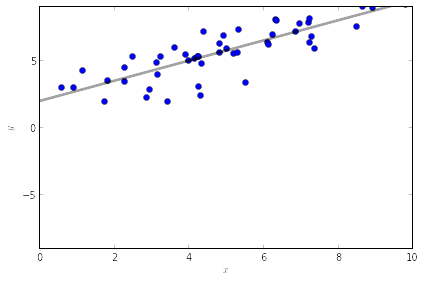

In [3]:

# Plot the dataset and the true model.
xl = np.array([0, 10])
pl.plot(x, y, 'o')
pl.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()

For the **emcee** library, one of the only things we need to provide is a function to evaluate the (log) posterior probability of a given value of the parameters. The function *lnprob()* below is what we'll feed in to the sampler generator. And, per Bayes rule, this function is a simple combination of lieklihood and prior.

So our likelihood is Normally distributed errors around the mean of the model prediction. In log-space, this just becomes the sum of squared errors.

In [4]:

# Define the probability function as likelihood * prior.
def lnprior(theta):
    m, b, sigma = theta
    if -5.0 < m < 5.0 and 0.0 < b < 10.0 and 0.0 < sigma < 10.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y):
    m, b, sigma = theta
    model = m * x + b
    inv_sigma2 = 1.0/( sigma**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob(theta, x, y):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

In [5]:
# Set up the sampler.
ndim, nwalkers = 3, 50
pos = [ 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y))

In [6]:
out = sampler.run_mcmc(pos, 1500, rstate0=np.random.get_state())

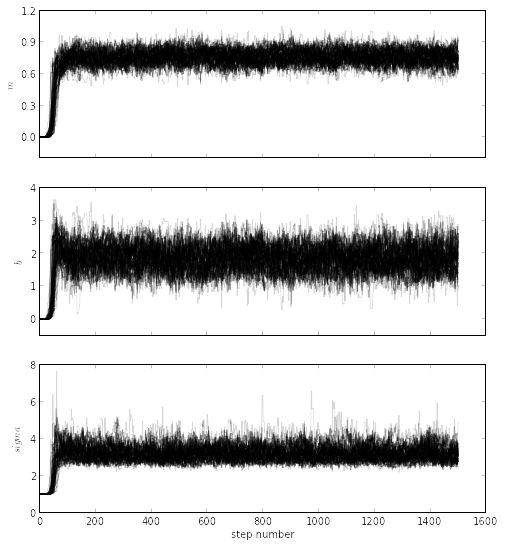

In [10]:

pl.clf()
fig, axes = pl.subplots(3, 1, sharex=True, figsize=(8, 9))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].set_ylabel("$m$")


axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].set_ylabel("$b$")

axes[2].plot(np.exp(sampler.chain[:, :, 2]).T, color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].set_ylabel("$sigma$")
axes[2].set_xlabel("step number")


In [31]:
samples = sampler.chain[:, 200:, :].reshape((-1, 3))

In [32]:
df = pd.DataFrame(samples, columns = ["m", "b", "sigma"])

The marginal posterior distribution of each parameter.

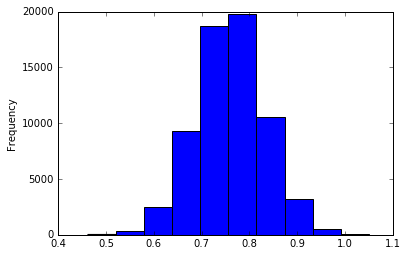

In [33]:
df.m.plot(kind="hist")

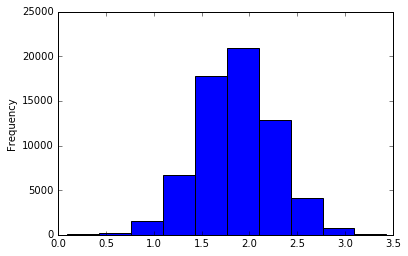

In [34]:
df.b.plot(kind="hist")

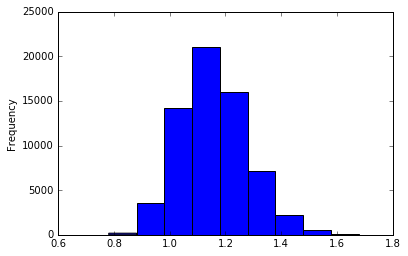

In [35]:
df.sigma.plot(kind="hist")

If you've got the **seaborn** library, I really like the function *seaborn.distplot()* on a data frame to look at the parameter correlations. But I can't get installation of seaborn to work on this machine at the moment...

In summary, the only interface between **emcee** and our models is that we supply some fixed data [*args = (x,y)* above] and then we supply a function which can evaluate the posterior probability of any point in the parameter space [*lnprob()* above].

So one change we might want to consider (though I currently have a work around) is that all of our models might need an additional method. Instead of just a *sim()* method that has the side effect of updating *self.output*, we might have each class also expose a public method for generating a binding curve from some input parameter values. 